# 循环神经网络

## 利用因变量自回归模型

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

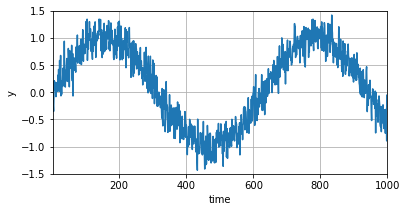

In [2]:
%matplotlib inline
T =1000
time = torch.arange(1,T+1,dtype  = torch.float32)
y = torch.sin(0.01*time)+torch.normal(0,0.2,(T,))
plt.figure(figsize=(6,3))
plt.plot(time,y)
plt.xlabel('time')
plt.ylabel('y')
plt.grid()   #有单元格
plt.axis([1,1000,-1.5,1.5]) #设置长宽比
plt.show()

In [3]:
import torch.utils.data as Data
tau = 4
features = torch.zeros((T-tau,tau))
for i in range(tau):
    features[:,i] = y[i:T-tau+i]  #竖着是y[i:T-tau+i]
labels = y[tau:].reshape(-1,1)

In [4]:
batch_size = 32
n_train = 600
train_s = Data.TensorDataset(features[:n_train],labels[:n_train])
train_iter = Data.DataLoader(train_s,batch_size)
## 初始化网络参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,1),
    )
    net.apply(init_weights)
    return net
loss = nn.MSELoss(reduction='none')

In [5]:
def train(net,train_iter,loss,epochs,lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for i,(X,y) in enumerate(train_iter):
            l = loss(net(X),y)
            trainer.zero_grad()
            l.sum().backward()
            trainer.step()
        print('epoch:{},Loss:{}'.format(epoch+1,l.sum()))
net = get_net()
train(net,train_iter,loss,20,0.01)

epoch:1,Loss:4.120824337005615
epoch:2,Loss:3.1383070945739746
epoch:3,Loss:2.9470832347869873
epoch:4,Loss:2.8311119079589844
epoch:5,Loss:2.5729856491088867
epoch:6,Loss:2.4977169036865234
epoch:7,Loss:2.428779125213623
epoch:8,Loss:2.3550169467926025
epoch:9,Loss:2.3055803775787354
epoch:10,Loss:2.2457404136657715
epoch:11,Loss:2.199753522872925
epoch:12,Loss:2.155869483947754
epoch:13,Loss:2.11140513420105
epoch:14,Loss:2.085014820098877
epoch:15,Loss:2.026900291442871
epoch:16,Loss:2.0320634841918945
epoch:17,Loss:1.9503084421157837
epoch:18,Loss:2.001922369003296
epoch:19,Loss:1.9172332286834717
epoch:20,Loss:1.9879223108291626


(0.0, 1000.0, -1.5, 1.5)

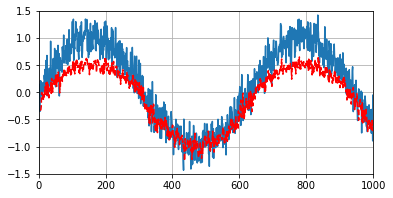

In [6]:
onestep_preds = net(features)
plt.figure(figsize=(6,3))
plt.plot(time,y,)
plt.plot(time[tau:],onestep_preds.detach(),'r--')
plt.grid()
plt.axis([0,1000,-1.5,1.5])

## 文本预处理

In [3]:
import collections
import re

In [4]:
# 读取数据集
def read_time_machine():
    with open('timemachine.txt','r',encoding='utf-8') as f:    
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+',' ',line).strip().lower() for line in lines]   #re.sub()正则表达式匹配  .strip（）首位字符消除  .lower()字母小写
lines = read_time_machine()
print('文本总行数{}'.format(len(lines)))
print(lines[0])

文本总行数3530
the time machine


In [5]:
# 词元化
def tokenize(lines, token='word'):  #@save
    """ 将文本拆分成为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines] #.split()按照空格分隔
    elif token == 'char':
        return[list(line) for line in lines]
    else:
        print('错误'+token)
tokens = tokenize(lines,'word')
for i in range(15):
    print(tokens[i])

['the', 'time', 'machine']
[]
['an', 'invention']
[]
['by', 'h', 'g', 'wells']
[]
[]
['contents']
[]
['i', 'introduction']
['ii', 'the', 'machine']
['iii', 'the', 'time', 'traveller', 'returns']
['iv', 'time', 'travelling']
['v', 'in', 'the', 'golden', 'age']
['vi', 'the', 'sunset', 'of', 'mankind']


In [6]:
# 词表
class Vocab:
    """文本词表"""
    def __init__(self,tokens=None,min_freq = 0,reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens =[]
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(),key = lambda x:x[1],   # 按照x[1]进行大小排序
                                   reverse =True)                         # reverse=True 从大到小排序
        #未知词元的索引为0
        self.idx_to_token = ['<unk>']+reserved_tokens                      # 预留多个文本保存
        self.token_to_idx = {token:idx 
                               for idx,token in enumerate(self.idx_to_token)
        }
        for token,freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)                                # self.idx_to_token存储了唯一词元
                self.token_to_idx[token] = len(self.idx_to_token)-1            # self.token_to_idx为字典；存储了唯一词元，与在idx_to_token中的下标
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self,tokens):                                              # 元素索引
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property                           # 将方法变成属性调用  
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs

    
def count_corpus(tokens): #@save
    """ 统计词元的频率"""
    #这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0],list):   #isinstance() 函数来判断一个对象是否是一个已知的类型，通常用于判断两个类型是否相同。
        # 将词元列表展成一个列表
        tokens = [token for line in tokens for token in line]   #二层循环
    return collections.Counter(tokens)      # 返回一个collections类，对其中元素进行计数

In [7]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('and', 2), ('of', 3), ('i', 4), ('a', 5), ('to', 6), ('in', 7), ('was', 8), ('that', 9)]


In [8]:
# 将每一条文本行转换成一个数字索引列表
for i in [13,14]:
    print('文本：',tokens[i])
    print('索引：',vocab[['v', 'in', 'the', 'golden', 'age']])

文本： ['v', 'in', 'the', 'golden', 'age']
索引： [1577, 7, 1, 556, 268]
文本： ['vi', 'the', 'sunset', 'of', 'mankind']
索引： [1577, 7, 1, 556, 268]


In [9]:
"""
整合所有功能
在使⽤上述函数时，我们将所有功能打包到load_corpus_time_machine函数中，该函数返回
corpus （词元索引列表）和vocab（时光机器语料库的词表）。我们在这⾥所做的改变是：
1.为了简化后⾯章节中的训练，我们使⽤字符（⽽不是单词）实现⽂本词元化；
2.时光机器数据集中的每个⽂本⾏不⼀定是⼀个句⼦或⼀个段落，还可能是⼀个单词，因此返回
的corpus仅处理为单个列表，⽽不是使⽤多词元列表构成的⼀个列表。
"""
def load_corpus_time_machine(max_tokens=-1): #@save
    """返回时光机器数据集的词元索引列表"""
    lines = read_time_machine()
    tokens = tokenize(lines,'char')         #返回单个字母的双层列表
    vocab = Vocab(tokens)                   
    #因为时光机器数据集中的每个⽂本⾏不⼀定是⼀个句⼦或⼀个段落，
    #所以将所有⽂本⾏展平到⼀个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:                      #corpus 为有多少语料作为输入
        corpus = corpus[:max_tokens]
    return corpus,vocab

corpus,vocab = load_corpus_time_machine()
len(corpus),len(vocab)

(188987, 28)

## 读取长序列

In [10]:
import random

In [67]:
"""
batch_size指定了每个小批量中子序列样本的数目
num_steps是每个子序列中预定义的时间步数
"""
# 随机采样
def seq_data_iter_random(corpus,batch_size,num_steps): 
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0,num_steps-1):]          # 选取随机偏移量之后的单词
    #random.randint() 函数返回参数1和参数2之间的任意整数， 闭区间
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus)-1) // num_steps               # num_subseqs:总体小批次的数目
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0,num_subseqs*num_steps,num_steps))
    # 在随机抽样的迭代过程中
    # 来自两个相邻的，随机的，小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)
        
    def data(pos):
        #返回从pos位置开始的长度为num_steps的序列
        return corpus[pos : pos+num_steps]
    
    num_batches = num_subseqs // batch_size  # 一个epoch有多少个批次   由于是整除，所以每次的batch_size都一致
    for i in range(0,batch_size * num_batches,batch_size):
        initial_indices_per_batch = initial_indices[i:i+batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X),torch.tensor(Y)               # yield 迭代器

In [59]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    """使⽤顺序分区⽣成⼀个⼩批量⼦序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [13]:
# 两个采样函数的合并成一个类
class SeqDataLoader:
    def __init__(self,batch_size,num_steps,use_random_iter,max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus,self.vocab =load_corpus_time_machine(max_tokens)
        self.batch_size,self.num_steps = batch_size,num_steps
    
    def __iter__(self):
        return self.data_iter_fn(self.corpus,self.batch_size,self.num_steps)

In [14]:
# 返回迭代器和词表
def load_data_time_machine(batch_size,num_steps,
                          use_random_iter=False,max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size,num_steps,use_random_iter,max_tokens)
    return data_iter,data_iter.vocab      # data_iter 为SeqDataLoader中数据迭代器 ，data_iter.vocab为语料

## 循环神经网络的从零开始实现

In [15]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
import d2l

In [16]:
batch_size,num_steps = 32,35  # 批次尺寸为32，时间步为35
train_iter,vocab = load_data_time_machine(batch_size,num_steps)

In [17]:
# 初始化模型参数
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size
    # 每个语料通过生成独热编码形成的输入，故而为vocab_size
    def normal(shape):
        return torch.randn(size=shape,device=device)* 0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs,num_hiddens))
    W_hh = normal((num_hiddens,num_hiddens))
    b_h = torch.zeros(num_hiddens,device=device)
    # 输出层参数
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)
    # 附加梯度
    params = [W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [32]:
# 循环神经网络模型
def init_rnn_state(batch_size,num_hiddens,device):                   #参数系数初始化
    return (torch.zeros((batch_size,num_hiddens),device=device),)
"""
为了定义循环神经⽹络模型，我们⾸先需要⼀个init_rnn_state函数在初始化时返回隐状态。这个函数的
返回是⼀个张量，张量全⽤0填充，形状为（批量⼤⼩，隐藏单元数）。在后⾯的章节中我们将会遇到隐状态
包含多个变量的情况，⽽使⽤元组可以更容易地处理些。
"""
def rnn(inputs,state,params):
    # inputs的形状：（时间步数量，批量大小，词表大小）
    W_xh,W_hh,b_h,W_hq,b_q = params
    H, = state
    outputs = []
    # x的形状：（批量大小，词表大小）
    for X in inputs:
        H = torch.tanh(torch.mm(X,W_xh)+torch.mm(H,W_hh) + b_h)   # 隐藏层的输出为更新后的H
        Y = torch.mm(H,W_hq) +b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)    # 将outputs里的列表按照dim的方向合并

class RNNModelScratch:
    def __init__(self,vocab_size,num_hiddens,device,               
                 get_params,init_state,forward_fn):
        self.vocab_size,self.num_hiddens = vocab_size,num_hiddens
        self.params = get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn = init_state,forward_fn
    
    def __call__(self,X,state):                                  # state为H  进行前向传播
        X = F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    
    def begin_state(self,batch_size,device):                    #系数初始化
        return self.init_state(batch_size,self.num_hiddens,device)

In [33]:
X = torch.arange(15).reshape((3, 5))
print(len(vocab))
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, 'cpu', get_params,init_rnn_state, rnn)
state = net.begin_state(X.shape[0], 'cpu')          # 这里就指定batch_size
Y, new_state = net(X, state)
Y.shape, len(new_state), new_state[0].shape

28


(torch.Size([15, 28]), 1, torch.Size([3, 512]))

In [47]:
# 预测
def predict_ch8(prefix,num_preds,net,vocab,device):
    state = net.begin_state(batch_size=1,device=device)         # 参数初始化
    outputs = [vocab[prefix[0]]]                                # 获得首字母的下标
    get_input = lambda:torch.tensor([outputs[-1]],device=device).reshape((1,1))    # 获得输入
    for y in prefix[1:]: # 预热期
        _,state = net(get_input(),state)
        outputs.append(vocab[y])       # 更新输入
    for _ in range(num_preds): # 预测num_preds步
        y,state = net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ',10,net,vocab,'cpu')

'time traveller dqwkxdqslu'

In [48]:
# 梯度剪裁
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2))for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta/norm

In [49]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer= None,d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和，词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第⼀次迭代或使⽤随机抽样时初始化state
            state = net.begin_state(batch_size = X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        print(X.shape)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调⽤了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(),y.numel())
        return math.exp(metric[0]/metric[1]),metric[1]/timer.stop()

In [50]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
        legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.3, 32085.8 词元/秒 cpu
time traveller s returnxvi after than a small clock and very del
traveller s returnxvi after than a small clock and very del


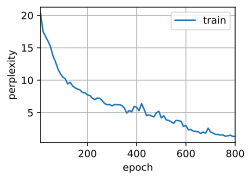

In [51]:
from d2l import torch as d2l
num_epochs, lr = 800, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, 'cpu')

困惑度 1.3, 36225.5 词元/秒 cpu
time traveller s returnxvi after somenils ca d ane ivithe no tha
traveller s returnxvi after sometime brightening in a quite


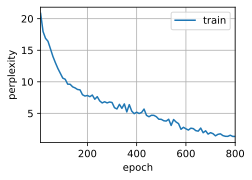

In [40]:
net = RNNModelScratch(len(vocab),num_hiddens,d2l.try_gpu(),get_params,init_rnn_state,rnn)
train_ch8(net,train_iter,vocab,lr,num_epochs,d2l.try_gpu(),use_random_iter=True)

In [29]:
# 循环神经网络的简洁实现
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [68]:
batch_size,num_steps = 32, 35
num_hiddens =256
rnn_layer = nn.RNN(len(vocab),num_hiddens)
state = torch.zeros((1,batch_size,num_hiddens))  # (隐藏层数，批量大小，隐藏单元)
X = torch.rand(size=(num_steps,batch_size,len(vocab)))
Y,state_new = rnn_layer(X,state) #通rnn_layer的“输出”（Y）不涉及输出层的计算：它是指每个时间步的隐状态，这些隐状态可以⽤作后续输出层的输⼊。
Y.shape,state_new.shape          # Y.shape = [time_step, batch_size, num_hiddens]   state_new.shape:[num_hiddens, batch_size ,num_hiddens]

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [31]:
class RNNModel(nn.Module):
    def __init__(self,rnn_layer,vocab_size,**kwargs):
        super(RNNModel,self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向，num_direction应该是2，否则是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens,self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens*2,self.vocab_size)
    
    def forward(self,inputs,state):
        X = F.one_hot(inputs.T.long(),self.vocab_size)          # .long() 返回长整型
        X = X.to(torch.float32)
        Y,state = self.rnn(X,state)
        # 全连接层将Y的形状改为（时间步数*批量大小，隐藏单元数）
        # 输出形式是（时间步数*批量大小，词表大小）
        output = self.linear(Y.reshape((-1,Y.shape[-1])))             
        return output, state
    
    def begin_state(self,device,batch_size=1):
        if not isinstance(self.rnn,nn.LSTM):
            # nn.GRU以张量作为隐状态
            return torch.zeros((self.num_directions * self.rnn.num_layers,
                               batch_size,self.num_hiddens),
                               device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size,self.num_hiddens),device=device),
                   torch.zeros((
                       self.num_directions*self.rnn.num_layers,
                       batch_size,self.num_hiddens),device=device))

In [32]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer,vocab_size = len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller',10,net,vocab,device)

'time travellerxxxxxxxxxx'

困惑度 1.3, 125640.5 词元/秒 cpu
time traveller for so it will be convenientep on armumtte be way
traveller smile fas in tiluged and iand wor sarke tout raci


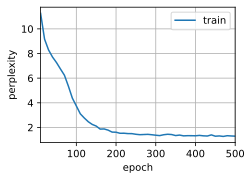

In [57]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

## 现代神经网络

### GRN

In [33]:
import torch 
from torch import nn
from d2l import torch as d2l

In [34]:
batch_size ,num_steps = 32,35
train_iter,vocab = load_data_time_machine(batch_size, num_steps)
# 初始化模型参数
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size = shape,device=device)*0.01
    
    def three():
        return (normal((num_inputs,num_hiddens)),
                normal((num_hiddens,num_hiddens)),
                torch.zeros(num_hiddens,device=device))
    
    W_xz, W_hz, b_z = three() # 更新门参数
    W_xr, W_hr, b_r = three() # 重置门参数
    W_xh, W_hh, b_h = three() # 候选隐状态参数
    # 输出层参数
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device = device)
    # 附加梯度
    params = [W_xz,W_hz,b_z,W_xr,W_hr,b_r,W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [35]:
# 定义模型
def init_gru_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

In [36]:
# 定义门控制单元
def gru(inputs,state,params):
    W_xz,W_hz,b_z,W_xr,W_hr,b_r,W_xh,W_hh,b_h,W_hq,b_q = params
    H, = state
    outputs =[]
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)

困惑度 8.5, 24412.9 词元/秒 cpu
time traveller an the the the the the the the the the the the th
traveller an the the the the the the the the the the the th


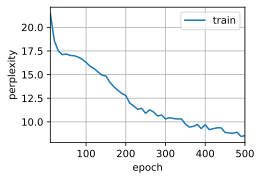

In [168]:
# 预测与训练
vocab_size, num_hiddens, device = len(vocab),256,d2l.try_gpu()
num_epochs,lr = 500,1
model = RNNModelScratch(len(vocab),num_hiddens,device,get_params,
                        init_gru_state,gru)
train_ch8(model,train_iter,vocab,lr,num_epochs,device)

困惑度 1.0, 36892.5 词元/秒 cpu
time traveller smiled are you so sure we can move freely inspace
traveller time astel they hust for instancethey taught you 


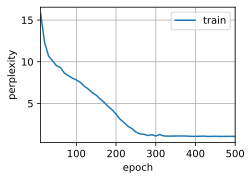

In [76]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### LSTM

In [37]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size,num_steps = 32,35
train_iter, vocab = load_data_time_machine(batch_size,num_steps)

In [38]:
def get_lstm_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        return torch.randn(size = shape ,device = device) * 0.01
    
    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens,device=device))
    
    W_xi, W_hi, b_i = three() # 输入门参数
    W_xf, W_hf, b_f = three() # 遗忘门参数
    W_xo, W_ho, b_o = three() # 输出门参数
    W_xc, W_hc, b_c = three() # 候选记忆门参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [39]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [40]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
    W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

困惑度 1.1, 25235.1 词元/秒 cpu
time traveller s returnxvi after the storyepilogueiintroductiont
travelleryter the psuched this in wroused as reatly have do


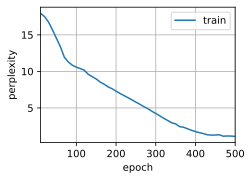

In [41]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

困惑度 1.1, 24379.5 词元/秒 cpu
time traveller s returnxvi after the storyepilogueiintroductiont
traveller thinger sone a methe time tion sannighin timetati


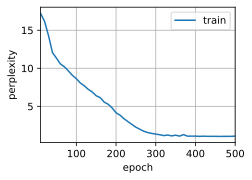

In [181]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

### 深度循环网络

In [42]:
import torch
from torch import nn
from d2l import torch as d2l
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [43]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = d2l.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)

困惑度 1.0, 10781.2 词元/秒 cuda:0
time traveller s returnxvi after the storyepilogueiintroductiont
traveller smiled are you so sure we can move freely inspace


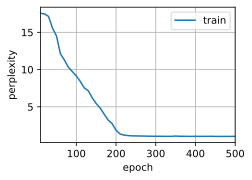

In [18]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)